In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.optimize
from sklearn.decomposition import FastICA, PCA

Let's start from the back here. These are the signals I injected (you didn't know this of course)

In [4]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

Ttrue = 3.3 # True value of the period!

s1 = np.sin(2*np.pi*time/ Ttrue)+ np.random.normal(1,0.3,size=len(time))  # Signal 1 : sinusoidal signal
s2 = np.random.normal(1,1,size=len(time))  # Signal 2 : white noise
s3 = signal.sawtooth(2 * np.pi * time)+np.random.normal(1,0.1,size=len(time))  # Signal 3: saw tooth signal

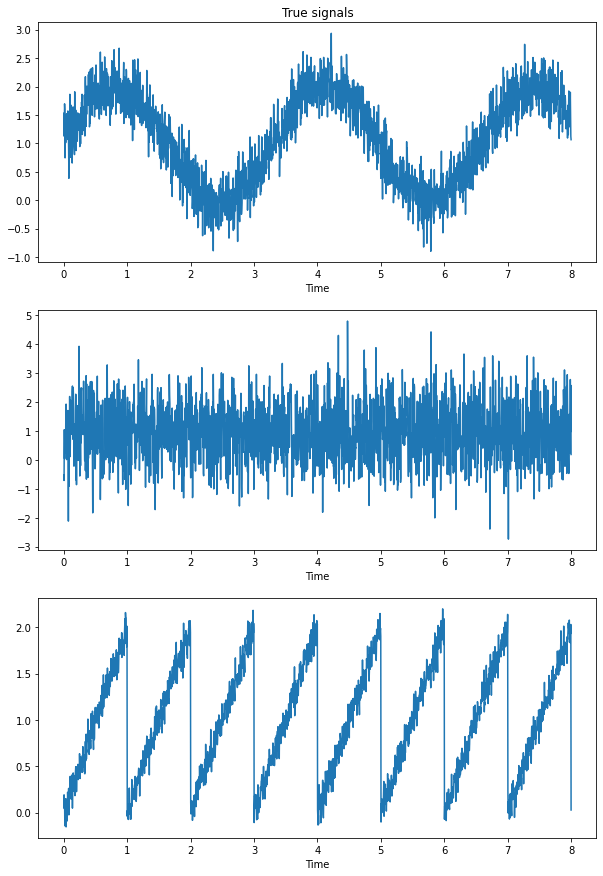

In [5]:
fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,[s1,s2,s3]):
    ax.plot(time,s,c='C0')
        
    ax.set_xlabel('Time')
    #ax.set_ylim(-1.1,1.1)
axs[0].set_title('True signals');

Then I mixed them together

In [6]:
S = np.c_[s1, s2, s3]
#S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data
A = np.array([[1, 1, 2], [0.5, 0.5, 0.5], [1, 0.5, 1]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

X.shape

np.save('noisydetector.npy',X)


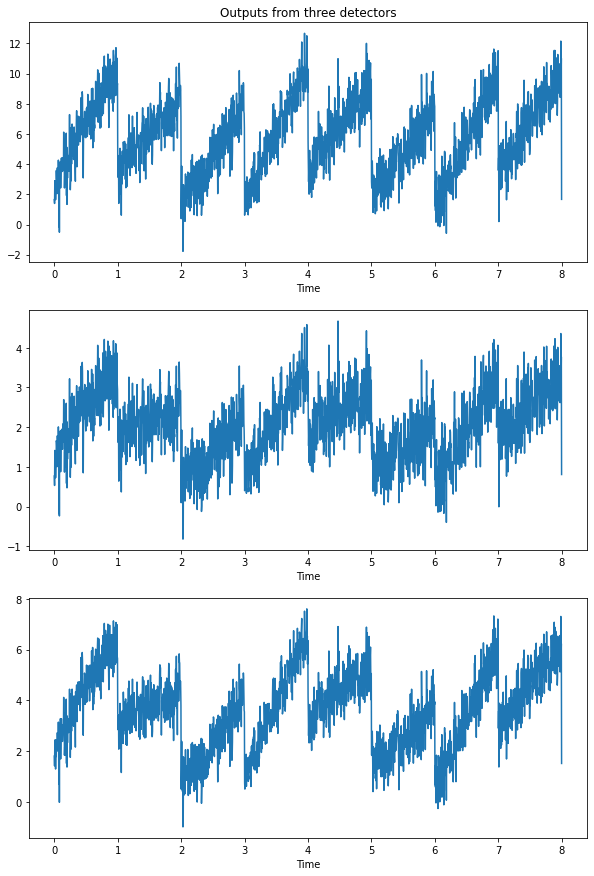

In [7]:
X=np.load('noisydetector.npy')

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');


Let's look at the PCA components first

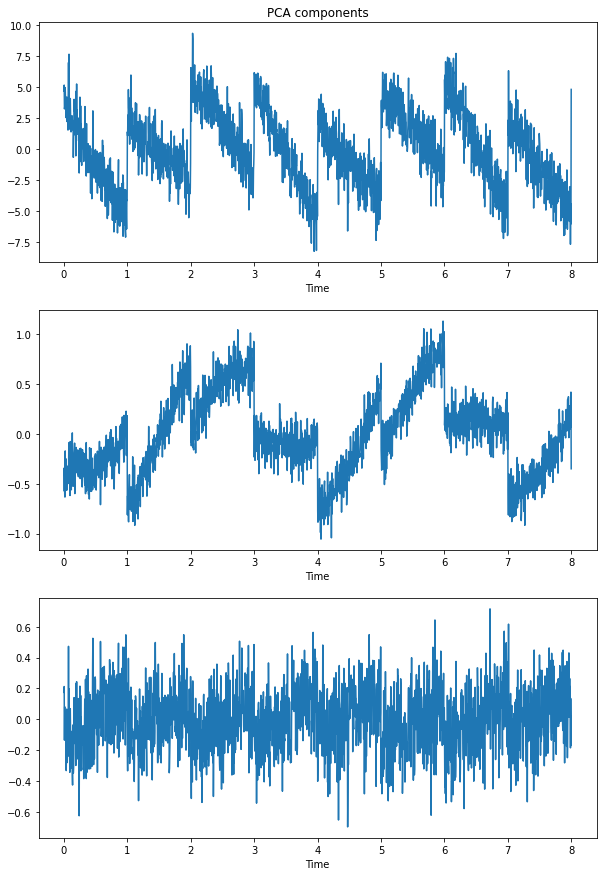

In [8]:
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,H.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('PCA components');

Mmmhhh... That second component seems to have a pediod close to three but it still contains some of the spike artifacts

Let's try ICA

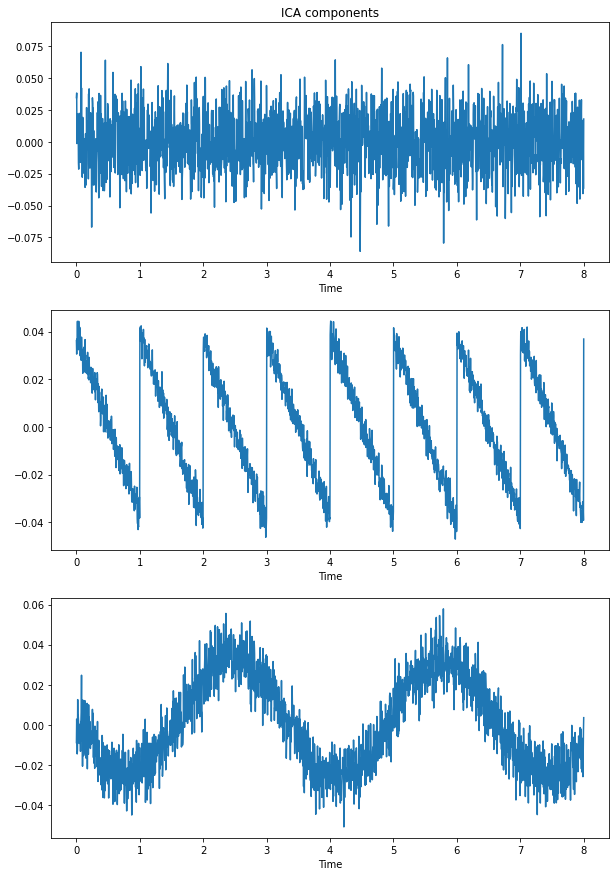

In [9]:
np.random.seed(42)

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,S_.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('ICA components');


Given that I'm using three components for a 3-dimensional dataset, the reconstruction should be exact.
Let's check, just to make sure I don't have a bug somewhere

In [10]:
np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

True

The third component is the signal I'm looking for!!!

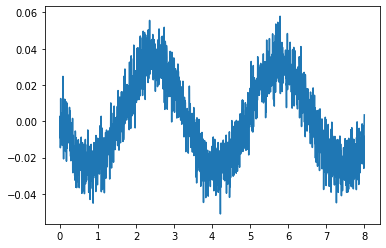

In [11]:
mysine = S_[:,2]
plt.plot(time,mysine)

Today I really feel like a frequentist. I'm going to do a least-square fit:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

If I were Bayesian, I would instead pick a prior and run an MCMC. 

In [12]:
def sinefunc(t,A,T,phi):
    return A*np.sin(2*np.pi*t/T+phi)

paropt,pcov = scipy.optimize.curve_fit(sinefunc,time,mysine, p0=[0.04,4,0])
perr = np.sqrt(np.diag(pcov))

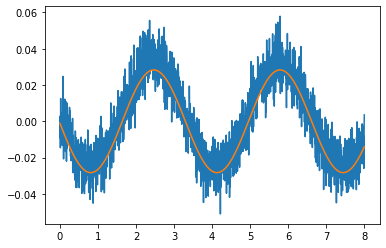

In [13]:
plt.plot(time, mysine)
bestmodel = sinefunc(time,*paropt)

plt.plot(time, bestmodel)

In [14]:
print("Recovered time", paropt[1], "+-", perr[1])
print("True value", Ttrue)

Recovered time 3.3180136281182557 +- 0.008230079104127149
True value 3.3


Could I use a least-square fit? Only if the errors are Gaussian. This is easy to check:



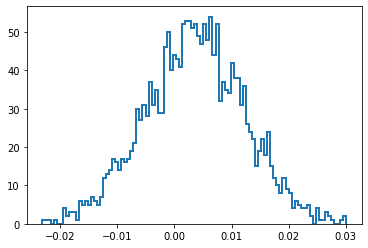

In [74]:
diff = mysine-bestmodel

plt.hist(mysine-bestmodel,bins =100, histtype='step',lw=2);

Which looks preety gaussian to me. We can run a vanilla test for Gaussianity (see [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) for details) to obtain a p-value

In [75]:
scipy.stats.normaltest(diff)

NormaltestResult(statistic=0.9604130470651093, pvalue=0.6186556116694357)

I'm overall happy with my result here, altough I have to admit my measurement is two sigma away from the true value.

In [76]:
(paropt[1] - Ttrue)/perr[1]

2.188755161444632

Could anyone do better?  Did anyone try with MCMC or nested sampling? What did you find?

If this was a real experiment, the first think would look into would be measurement errors, which is something I am completely neglecting (and they were not provided in the assignment...)